# Analyzing whether riders tend to have better results in their home country

load packages

In [337]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import math
from sklearn.utils import resample
import random

load cleaned data (this was done the the expoloratory_data_analyis_and_transformation notebook)

In [248]:
d=pd.read_csv('data/cleaned_downhill_data.csv')

## Summary

The primary question we are addressing with this analysis is: Do world cup riders race better or worse in their home country? We are going to operationalize this in four distict ways for our analysis:
1. Across all riders with more than 20 would cup results is the liklehood of rider having a good result relative to their other performances increased when they are racing in their home country?
2. Evaluting riders in the same way is the liklihood of bad results higher for riders racing their home country?
3. Which riders show the biggest positive and negative effects of racing their home country?
4. Are home country racers overrepresented among world cup winners?

# 1.) on average does racing at home increase the liklihood of having a good result?

We define a good result as one in the top 25% of a riders performances and use logistic regression to test this hypothesis (done in prior notebook)

We are going to bootstrapp this so that we can get a confidence interval on the effect of racing at home 

In [386]:

iterations=10000

model_characteristics=pd.DataFrame()
for i in range(iterations):
    
    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train = resample(modeling_data, replace=True, n_samples=int(len(modeling_data)*0.8))
    test = modeling_data[~modeling_data.index.isin(train.index)]
    
    x_train = np.array(train.loc[:, ["home_race"]])
    y_train = np.array(train.loc[:, ["best_results"]])

    x_test = np.array(test.loc[:, ["home_race"]])
    y_test = np.array(test.loc[:, ["best_results"]])

    logreg = LogisticRegression(random_state=16)
    logreg.fit(x_train,np.ravel(y_train))
    out_of_country_prob=math.exp(logreg.intercept_)/(1+math.exp(logreg.intercept_))
    in_country_prob=(math.exp(logreg.intercept_)+logreg.coef_)/(1+math.exp(logreg.intercept_+logreg.coef_))

    output_dict=pd.DataFrame({'Probability_in_country':[in_country_prob.item()],
                              'effect_of_racing_at_home':[math.exp(logreg.coef_)-1],
                              'classificaiton_accuracy':[logreg.score(x_test,np.ravel(y_test))],
                             'Probability_out_of_country':[out_of_country_prob]})
    model_characteristics=pd.concat([model_characteristics,output_dict],axis=0, ignore_index=True)


The estiamte of the effect of racing at home is presented here as the increase in the liklihood of a good result when racing in your home country

<AxesSubplot:xlabel='effect_of_racing_at_home', ylabel='Count'>

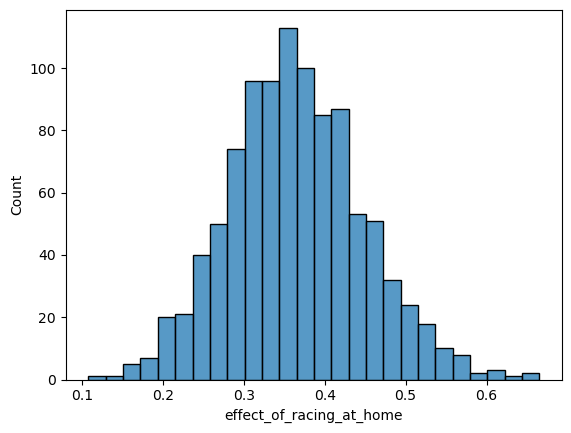

In [237]:
sns.histplot(data=model_characteristics,x='effect_of_racing_at_home')

Median and 95% confinednce intervale of the effect size. Racing at home give you between a 21 and 54% better chance of having a good result

In [238]:
np.quantile(model_characteristics['effect_of_racing_at_home'],[0.025,0.5,0.975])

array([0.20884054, 0.35916283, 0.53851904])

Riders have a 36% higher chance of having a good result when racing in their home country

## 2.) On average does racing at home give riders a higher liklihood of having a bad result?

Doing the same thing here but changing the response variable to be bad race results 

In [387]:

iterations=10000

model_characteristics_worst=pd.DataFrame()
for i in range(iterations):
    
    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train = resample(modeling_data, replace=True, n_samples=int(len(modeling_data)*0.8))
    test = modeling_data[~modeling_data.index.isin(train.index)]
    
    x_train = np.array(train.loc[:, ["home_race"]])
    y_train = np.array(train.loc[:, ["worst_results"]])

    x_test = np.array(test.loc[:, ["home_race"]])
    y_test = np.array(test.loc[:, ["worst_results"]])

    logreg = LogisticRegression(random_state=16)
    logreg.fit(x_train,np.ravel(y_train))
    out_of_country_prob=math.exp(logreg.intercept_)/(1+math.exp(logreg.intercept_))
    in_country_prob=(math.exp(logreg.intercept_)+logreg.coef_)/(1+math.exp(logreg.intercept_+logreg.coef_))

    output_dict=pd.DataFrame({'Probability_in_country':[in_country_prob.item()],
                              'effect_of_racing_at_home':[math.exp(logreg.coef_)-1],
                              'classificaiton_accuracy':[logreg.score(x_test,np.ravel(y_test))],
                             'Probability_out_of_country':[out_of_country_prob]})
    model_characteristics_worst=pd.concat([model_characteristics_worst,output_dict],axis=0, ignore_index=True)


<AxesSubplot:xlabel='effect_of_racing_at_home', ylabel='Count'>

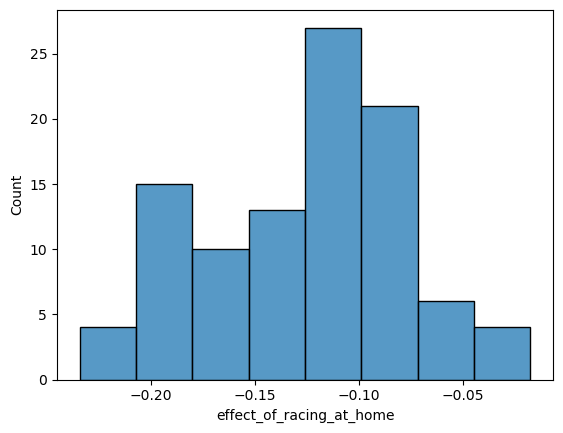

In [126]:
sns.histplot(data=model_characteristics_worst,x='effect_of_racing_at_home')

In [84]:
np.quantile(model_characteristics_worst['LR_coef_transformed'],[0.025,0.5,0.975])

array([-0.23889399, -0.13538299, -0.02591385])

Chances of having a bad race result are lower when racing at home by between 3 and 24%

### Graphing results of logistic regressions

In [240]:
graph_data_good=pd.DataFrame({'Location':['Home Country','Away'],
                              'Probability of Good result':[model_characteristics['Probability_in_country'].mean(),
                                                           model_characteristics['Probability_out_of_country'].mean()],
                             'lower_ci':[np.quantile(model_characteristics['Probability_in_country'],0.025),
                                        np.quantile(model_characteristics['Probability_out_of_country'],0.025)],
                             'upper_ci':[np.quantile(model_characteristics['Probability_in_country'],0.975),
                                        np.quantile(model_characteristics['Probability_out_of_country'],0.975)]})

graph_data_bad=pd.DataFrame({'Location':['Home Country','Away'],
                              'Probability of bad result':[model_characteristics_worst['Probability_in_country'].mean(),
                                                           model_characteristics_worst['Probability_out_of_country'].mean()],
                             'lower_ci':[np.quantile(model_characteristics_worst['Probability_in_country'],0.025),
                                        np.quantile(model_characteristics_worst['Probability_out_of_country'],0.025)],
                             'upper_ci':[np.quantile(model_characteristics_worst['Probability_in_country'],0.975),
                                        np.quantile(model_characteristics_worst['Probability_out_of_country'],0.975)]})

Text(0.5, 1.0, 'Good Results')

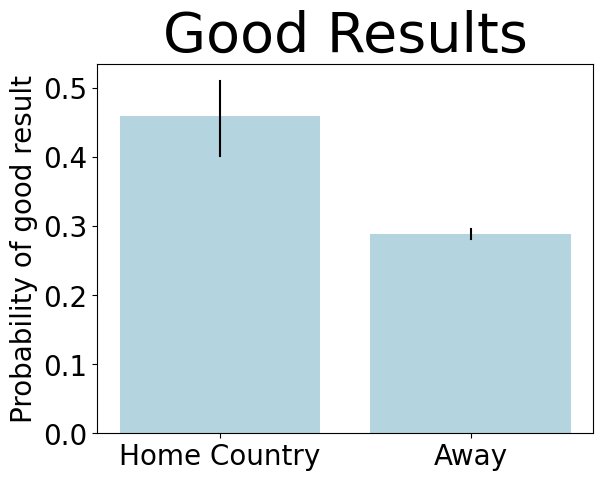

In [157]:
sns.barplot(x="Location", y="Probability of Good result",estimator=np.mean, data=graph_data_good, color='lightblue')
plt.plot(np.asarray([[0, 0], [1, 1]]).T, np.asarray([graph_data_good.iloc[0,2:4], graph_data_good.iloc[1,2:4]]).T, color='black')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("")
plt.ylabel("Probability of good result", fontsize=20)
plt.title('Good Results', fontsize=40)

Text(0.5, 1.0, 'Bad Results')

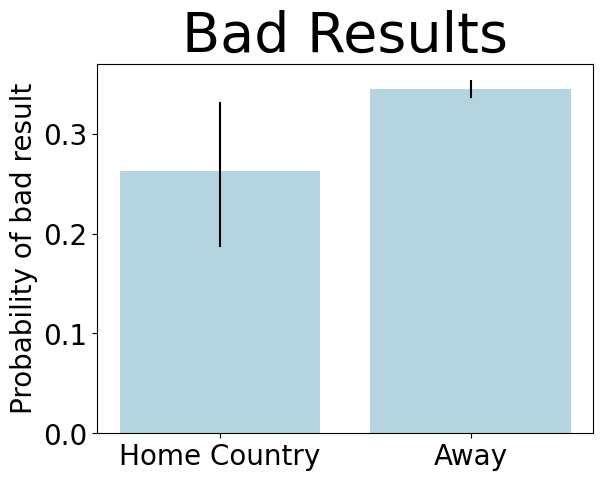

In [160]:
sns.barplot(x="Location", y="Probability of bad result",estimator=np.mean, data=graph_data_bad, color='lightblue')
plt.plot(np.asarray([[0, 0], [1, 1]]).T, np.asarray([graph_data_bad.iloc[0,2:4], graph_data_bad.iloc[1,2:4]]).T, color='black')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("")
plt.ylabel("Probability of bad result", fontsize=20)
plt.title('Bad Results', fontsize=40)

# 3.) which riders show the biggest effects from racing at home?

In [241]:
rider_models=pd.DataFrame()
for Name in modeling_names:
    one_rider_data=d[d['Name']==Name]
    one_rider_data

    x = np.array(one_rider_data.loc[:, ["home_race"]])
    y_bad = np.array(one_rider_data.loc[:, ["worst_results"]])
    y_good = np.array(one_rider_data.loc[:, ["best_results"]])
    try:
        logreg_bad = LogisticRegression(random_state=16)
        logreg_bad.fit(x,np.ravel(y_bad))
        logreg_good = LogisticRegression(random_state=16)
        logreg_good.fit(x,np.ravel(y_good))
        good_result_effect=math.exp(logreg_good.coef_)-1
        bad_result_effect=math.exp(logreg_bad.coef_)-1
        output_dict=pd.DataFrame({'rider':[Name],'good_result_effect':[good_result_effect],'bad_result_effect':[bad_result_effect]})
        rider_models=pd.concat([rider_models,output_dict],axis=0, ignore_index=True)
    except:
        print(Name,"sum of home races is",one_rider_data['home_race'].sum())

Anne-Caroline CHAUSSON sum of home races is 9
Gerard WOLFE sum of home races is 7
Iraitz ETXEBARRIA sum of home races is 0
Kristof LENSSENS sum of home races is 0
Marco Aurélio SILVA FIDALGO sum of home races is 0
Markus PLANITZER sum of home races is 4
Niko VELASCO sum of home races is 0
Oliver MORRIS (elt) sum of home races is 2
Ondrej BARTA sum of home races is 0
Pavel CEP sum of home races is 0
Robert SMITH (elt) sum of home races is 11


In [276]:
rider_models.set_index('rider')
biggest_effects=rider_models['good_result_effect'].sort_values(ascending=True).head(10)
biggest_effects.index
best_effects=rider_models.loc[biggest_effects.index]
best_effects_riders=best_effects['rider']
best_effects

,rider,good_result_effect,bad_result_effect
193,Jonty NEETHLING,4.207584,-0.751699
336,Rastislav BARANEK,3.209102,-0.417042
184,Joe SMITH (elt),3.171387,-0.542872
32,Ben CATHRO,2.840883,-0.306367
46,Bryan PFEIFFER,2.679183,-0.668003
364,Scott MEARS,2.480423,-0.590074
172,Janis LEHMANN,2.427830,-0.818995
106,Emanuel POMBO,2.318515,-0.502427
223,Lachlan BLAIR,2.266336,-0.690705
130,Fraser MCGLONE,2.257654,-0.673034


In [258]:
bad_results=['DNF','DNQ','DSQ','DNS','',np.nan]
plot_data=d[~d['Run 1'].isin(list(bad_results))]
plot_data['percent_time_back']=plot_data['percent_time_back']+0.008
home_races=plot_data[plot_data['home_race']==1]


C:\Users\nt78066\AppData\Local\Temp\ipykernel_13464\4132970247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['percent_time_back']=plot_data['percent_time_back']+0.008


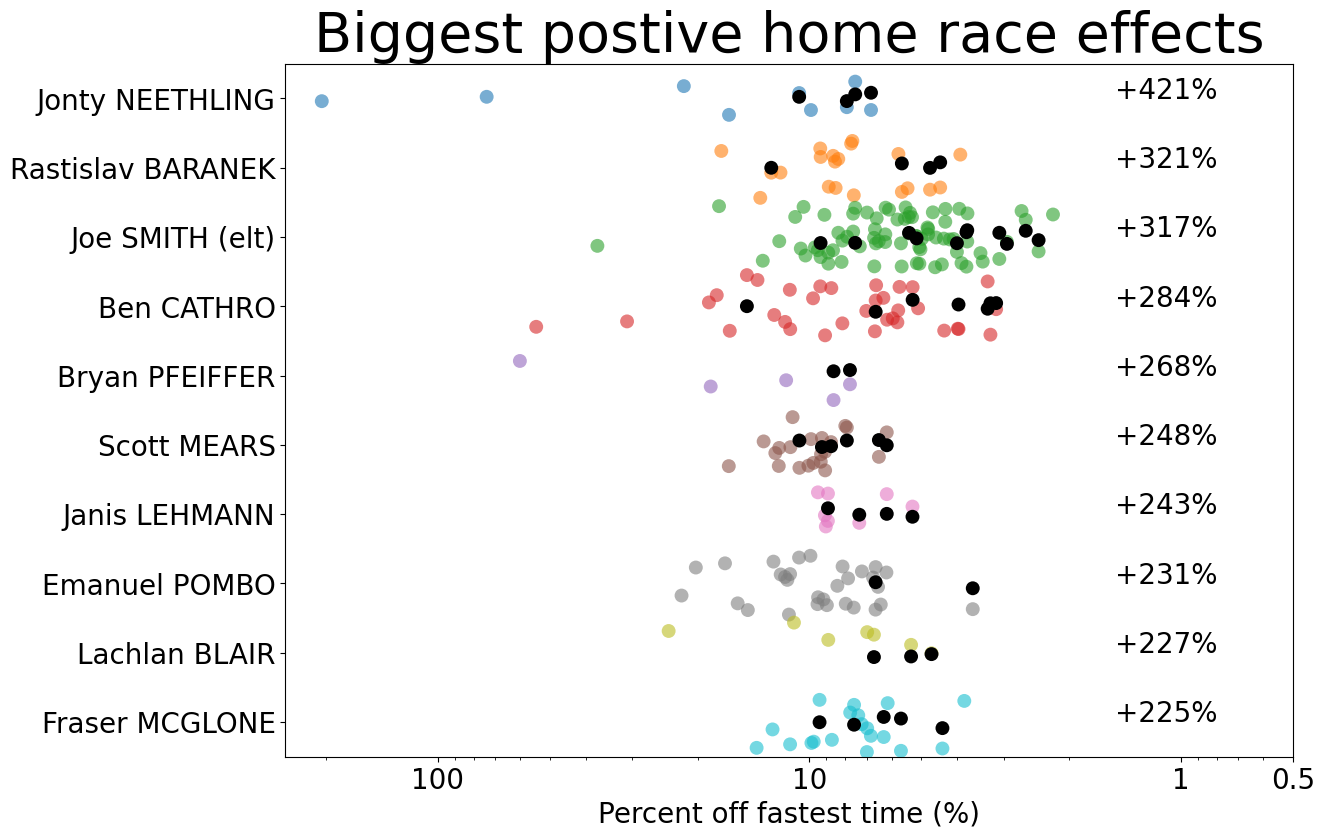

In [321]:
plt.figure(figsize=(13,9))
ax=sns.stripplot(data=plot_data[plot_data['Name'].isin(list(best_effects_riders))],x='percent_time_back',y="Name",order=list(best_effects_riders),alpha=0.6,
             jitter=0.45,size=10)
sns.stripplot(data=home_races[home_races['Name'].isin(list(best_effects_riders))],x='percent_time_back',y="Name",order=list(best_effects_riders),palette=['black'],size=10, ax=ax)
plt.xlabel("Percent off fastest time (%)", fontsize=20)
plt.ylabel("")
plt.title('Biggest postive home race effects', fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale('log')
plt.xticks([0.5,1,10,100],['0.5','1','10','100'])
#plt.axvline(x = 0.008, color = 'b', label = 'Race winning time')
for i in range(10):
    ax.annotate(str("+" + str(int(best_effects['good_result_effect'].iloc[i].round(2)*100))+'%'),
            xy=(1.5, i), xycoords='data',fontsize=20)
    
plt.gca().invert_xaxis()

<AxesSubplot:xlabel='percent_time_back', ylabel='Count'>

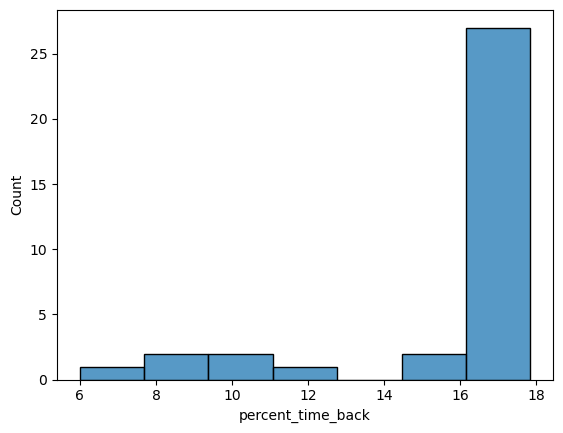

In [243]:
sns.histplot(data=one_rider_data,x='percent_time_back')

In [323]:
rider_models.set_index('rider')
biggest_effects=rider_models['bad_result_effect'].sort_values(ascending=False).head(10)
biggest_effects.index
worst_effects=rider_models.loc[biggest_effects.index]
worst_effects_riders=worst_effects['rider']
worst_effects

,rider,good_result_effect,bad_result_effect
143,Glyn O'BRIEN,-0.147111,3.024959
276,Maxime REMY,-0.416668,2.632194
210,Karim AMOUR,-0.259218,2.150784
27,Arnelie THÉVOZ,-0.317148,1.933143
133,Gaetan VIGE,-0.400555,1.902620
359,Sandra WALKER,-0.323658,1.850308
251,Marine CABIROU,-0.361718,1.723848
352,Rüdiger JAHNEL,-0.569158,1.688573
157,Helene Valerie FRUHWIRTH,-0.170577,1.686812
182,Joe BREEDEN,-0.367458,1.652283


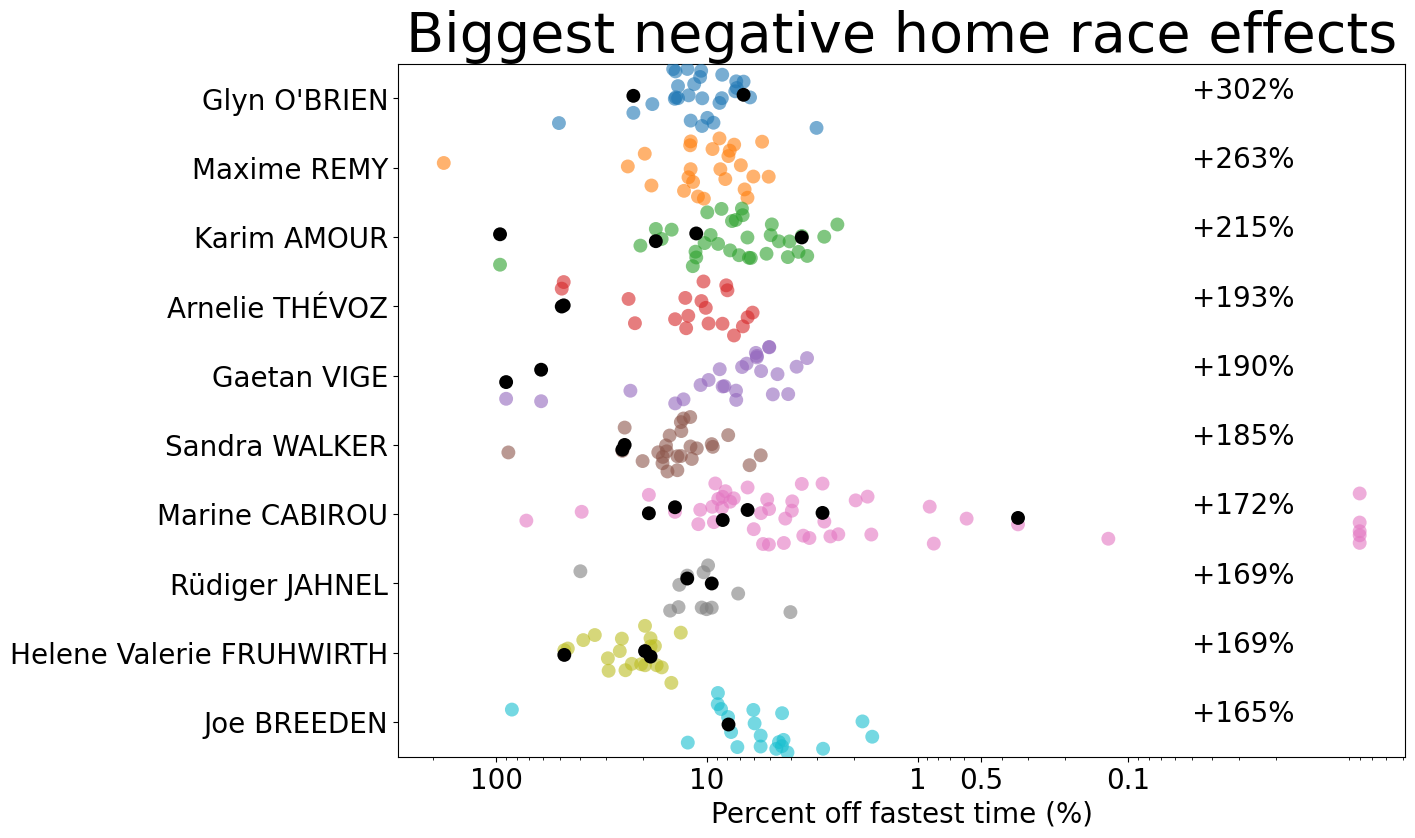

In [326]:
plt.figure(figsize=(13,9))
ax=sns.stripplot(data=plot_data[plot_data['Name'].isin(list(worst_effects_riders))],x='percent_time_back',y="Name",order=list(worst_effects_riders),alpha=0.6,
             jitter=0.45,size=10)
sns.stripplot(data=home_races[home_races['Name'].isin(list(worst_effects_riders))],x='percent_time_back',y="Name",order=list(worst_effects_riders),palette=['black'],size=10, ax=ax)
plt.xlabel("Percent off fastest time (%)", fontsize=20)
plt.ylabel("")
plt.title('Biggest negative home race effects', fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale('log')
plt.xticks([0.1,0.5,1,10,100],['0.1','0.5','1','10','100'])
#plt.axvline(x = 0.008, color = 'b', label = 'Race winning time')
for i in range(10):
    ax.annotate(str("+" + str(int(worst_effects['bad_result_effect'].iloc[i].round(2)*100))+'%'),
            xy=(0.05, i), xycoords='data',fontsize=20)
    
plt.gca().invert_xaxis()

# 4.) Are home country winners overrepresented in world cup results?

In [356]:
winners=d[d['percent_time_back']==0]
men_winners=winners[winners['sex']=='Men']
women_winners=winners[winners['sex']=='Women']

How many wins were in a home country?

In [336]:
print(men_winners['home_race'].sum(),'men won at home')
print(women_winners['home_race'].sum(),'women won at home')

21 men won at home
24 women won at home


In [372]:
iterations=10000
randomization_test=pd.DataFrame()
men_races=list(men_winners['race_country'])
women_races=list(women_winners['race_country'])

for i in range(iterations):
    mens=sum(men_winners['rider_country_new']==random.sample(list(men_winners['race_country']),len(list(men_winners['race_country']))))
    womens=sum(women_winners['rider_country_new']==random.sample(list(women_winners['race_country']),len(list(women_winners['race_country']))))
    output=pd.DataFrame({'mens':[mens],'womens':[womens]})
    randomization_test=pd.concat([randomization_test,rider_models,output],axis=0, ignore_index=True)

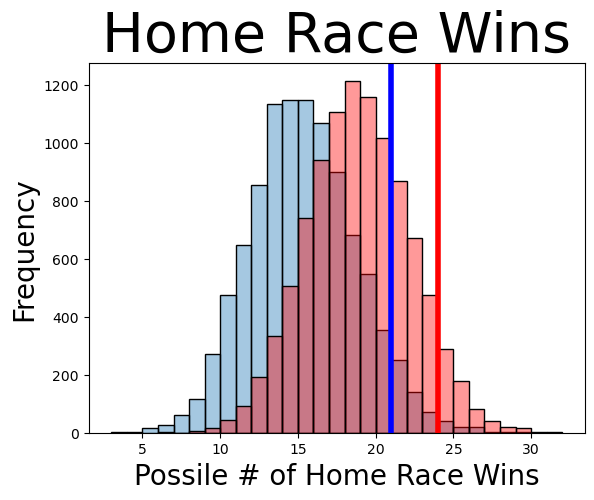

In [413]:
ax=sns.histplot(data=randomization_test,x='mens',alpha=0.4,binwidth=1)
sns.histplot(data=randomization_test,x='womens',alpha=0.4,ax=ax,color='red',binwidth=1)
plt.xlabel("Possile # of Home Race Wins", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title('Home Race Wins', fontsize=40)
plt.axvline(x = 24, color = 'red', label = 'Race winning time',linewidth=4)
plt.axvline(x = 21, color = 'blue', label = 'Race winning time',linewidth=4)

In [377]:
len(randomization_test[randomization_test['mens']<21])/iterations

0.945

In [378]:
len(randomization_test[randomization_test['womens']<21])/iterations

0.736

In [380]:
rider_models[rider_models['good_result_effect']>0]

,rider,good_result_effect,bad_result_effect
0,Aaron GWIN,0.431925,0.020710
2,Adam ROJCEK,1.640739,-0.317715
4,Alan BEGGIN,1.522583,-0.131623
11,Amaury PIERRON,0.106248,-0.278680
12,Andre WAGENKNECHT,0.361870,-0.516113
...,...,...,...
394,Tracey HANNAH,0.165649,0.133146
395,Tracy MOSELEY,1.740439,-0.689557
396,Troy BROSNAN,0.181622,0.150875
398,Valentin CHATANAY,0.676072,-0.448711


In [381]:
rider_models

,rider,good_result_effect,bad_result_effect
0,Aaron GWIN,0.431925,0.020710
1,Adam BRAYTON,-0.198773,-0.087061
2,Adam ROJCEK,1.640739,-0.317715
3,Adam VAGNER,0.000000,0.000000
4,Alan BEGGIN,1.522583,-0.131623
...,...,...,...
409,Yuki KUSHIMA,0.000000,0.000000
410,Zakarias JOHANSEN,0.000000,0.000000
411,Zarja CERNILOGAR,0.000000,0.000000
412,Ziga PANDUR,-0.128167,0.430705


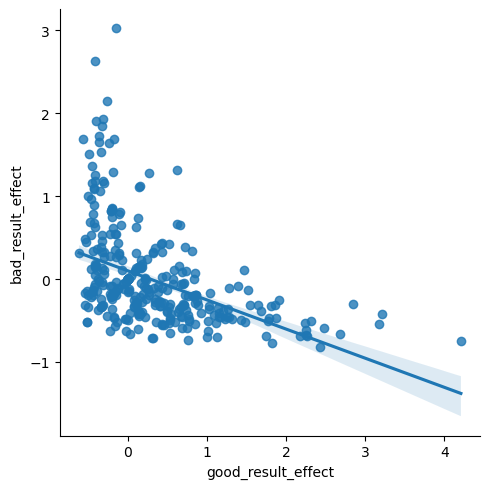

In [383]:
sns.lmplot(
    data=rider_models,
    x="good_result_effect", y="bad_result_effect"
)

In [385]:
rider_models[(rider_models['good_result_effect']>0) & (rider_models['bad_result_effect']>0)]

,rider,good_result_effect,bad_result_effect
0,Aaron GWIN,0.431925,0.020710
39,Bernat GUÀRDIA PASCUAL,0.152757,0.152757
47,Bryn ATKINSON,0.157168,0.157168
69,Connor FEARON,0.213136,0.009629
75,Cyrille KURTZ,0.274731,1.281395
77,Céline GROS,0.645923,0.162261
83,Dan STANBRIDGE,0.734097,0.102107
86,David SMITH (exp),0.109412,0.130785
99,Ed MOSELEY,0.182463,0.182463
107,Emilie SIEGENTHALER,0.624756,1.310443


In [418]:
len(d)

18888

In [416]:
d.head()

,Unnamed: 0,Name,Name.1,Run 1,sex,rider_country,race_country,Date,track_name,rider_country_new,home_race,run_time,race_id,percent_time_back,best_results,worst_results
0,0,Nicolas VOUILLOZ,Nicolas VOUILLOZ,5:57.981,Men,French,Germany,23rd Sep 1995,Kirchzarten,France,0,5.966350,Kirchzarten23rd Sep 1995,0.000000,1,0
1,2,Mike KING (pro),Mike KING (pro),6:07.083,Men,American,Germany,23rd Sep 1995,Kirchzarten,USA,0,6.118050,Kirchzarten23rd Sep 1995,2.542593,1,0
2,3,Tomas MISSER,Tomas MISSER,6:10.384,Men,Spanish,Germany,23rd Sep 1995,Kirchzarten,Spain,0,6.173067,Kirchzarten23rd Sep 1995,3.464709,0,0
3,4,Scott SHARPLES,Scott SHARPLES,6:11.405,Men,Australian,Germany,23rd Sep 1995,Kirchzarten,Australia,0,6.190083,Kirchzarten23rd Sep 1995,3.749920,0,0
4,5,Christian TAILLEFER,Christian TAILLEFER,6:12.916,Men,French,Germany,23rd Sep 1995,Kirchzarten,France,0,6.215267,Kirchzarten23rd Sep 1995,4.172009,1,0


In [419]:
graph_data_good

,Location,Probability of Good result,lower_ci,upper_ci
0,Home Country,0.459917,0.401163,0.514300
1,Away,0.289410,0.281591,0.297029


In [421]:
len(winners['rider_country'].unique())

13

In [422]:
rider_models.to_csv("data/rider_home_race_effects.csv")